In [1]:
import pandas as pd
import pickle

In [2]:
with open('vectors.pkl', 'rb') as f:
    vectors = pickle.load(f)

In [3]:
whole_df = pd.read_csv('preprocessed_data.csv')
whole_df.set_index('id', inplace=True)

In [4]:
non_normalized_df = pd.read_csv('non_normalized_data.csv')
non_normalized_df.set_index('id', inplace=True)

In [5]:
target_variables = ['polintr', 'psppsgva', 'actrolga']
target_variables = ['polintr']

In [6]:
def drop_missing_values(df):
    return df[~df.isin([77, 88, 99]).any(axis=1)]

In [7]:
whole_df = drop_missing_values(whole_df)
non_normalized_df = drop_missing_values(non_normalized_df)

In [8]:
df = whole_df[whole_df.columns.difference(target_variables)]

In [9]:
def process_row(row):
    country_code = row.name[:2]
    row_vector = 0

    for col, value in row.items():
        if value==77:
            row_vector += vectors[col][country_code][1]
        elif value==88:
            row_vector += vectors[col][country_code][2]
        elif value==99:
            row_vector += vectors[col][country_code][3]
        else:
            row_vector += value * vectors[col][country_code][0]

    return row_vector

In [10]:
participants = df.apply(lambda x: process_row(x), axis=1).to_dict()
participants = {
    p: {'embedding': v, 'projections':{}, 'predictions':{}, 'gold':{}} for p, v in participants.items()
}

In [11]:
with open('participants.pkl', 'wb') as f:
    pickle.dump(participants, f, protocol=pickle.HIGHEST_PROTOCOL)

# Projections

In [12]:
import numpy as np
from collections import defaultdict

In [13]:
distributions = defaultdict(list)

for target in target_variables:
    for participant, values in participants.items():
        country = participant[:2]
        target_vector = vectors[target][country][0]

        length_of_projection = (
            np.dot(target_vector, values["embedding"]) / 
            np.linalg.norm(values["embedding"])
        )

        distributions[target].append(length_of_projection)

        participants[participant]["projections"][target] = length_of_projection
        participants[participant]['gold'][target] = non_normalized_df.loc[participant][target]

# Distributions

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
def show_hist(sample):
    plt.figure(figsize=(10, 6))
    sns.histplot(sample, kde=False, bins=30) 
    plt.title('Histogram of the Sample')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.show()

In [16]:
def show_density(sample, title='', show=False):
    # plt.figure(figsize=(5, 3))
    sns.kdeplot(sample, fill=True)
    # plt.title(f'Density Plot of the {title}')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.legend(title)
    if show:
        plt.show()

In [17]:
# show_density(distributions['actrolga'], title='actrolga')
# show_density(distributions['polintr'], title='polintr')
# show_density(distributions['psppsgva'], title='psppsgva')

In [18]:
gold_distributions = {}
for target in target_variables:
    gold_distributions[target] = whole_df[~whole_df[target].isin([77, 88, 99])][target].to_numpy()

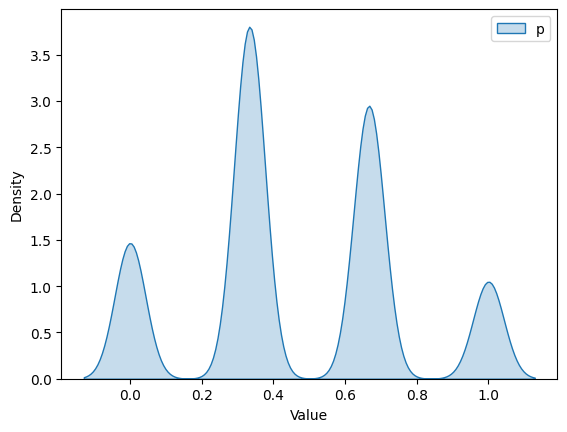

In [19]:
# show_density(gold_distributions['actrolga'], title='actrolga')
show_density(gold_distributions['polintr'], title='polintr')
# show_density(gold_distributions['psppsgva'], title='psppsgva')

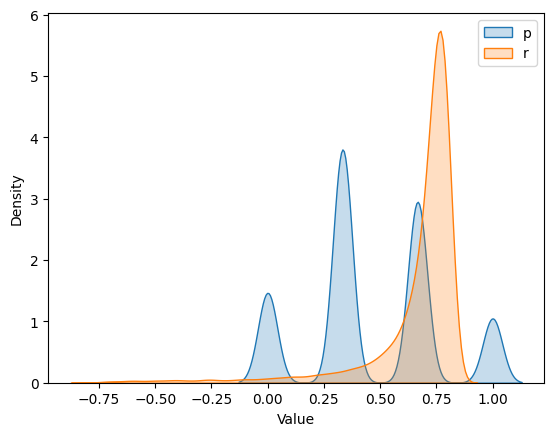

In [20]:
show_density(gold_distributions['polintr'], title='gold')
show_density(distributions['polintr'], title='pred')

# Predictions

In [22]:
import json

In [23]:
with open("codebook.json", "r") as codebook_file:
    codebook = json.load(codebook_file)

In [24]:
def get_intervals(array, num_of_choices, cutoff=60):
    lower_bound = np.percentile(array, cutoff/2)
    upper_bound = np.percentile(array, 100-(cutoff/2))
    step_size = (upper_bound - lower_bound) / num_of_choices
    intervals = [lower_bound + i * step_size for i in range(num_of_choices + 1)]
    return intervals


In [38]:
def find_interval(value, intervals, choices):
    if value < intervals[0]:
        return choices[0]
    
    if value > intervals[-1]:
        return choices[-1]
    
    for i in range(len(intervals) - 1):
        if intervals[i] <= value < intervals[i + 1]:
            return choices[i]


In [39]:
for t in target_variables:
    choices = codebook[t]['values']
    intervals = get_intervals(distributions[t], len(choices), 0)

    for p in participants.keys():
        participants[p]['predictions'][t] = find_interval(participants[p]['projections'][t], intervals, choices)

IndexError: list index out of range

In [27]:
predicted_distributions = {
    t:[
        participants[p]['predictions'][t]
        for p in participants
    ]
    for t in target_variables
}

In [28]:
all_predictions = {}
for t in target_variables:
    predictions = []
    golds = []
    for p in participants:
        if participants[p]['gold'][t] not in [77, 88, 99]:
            predictions.append(
                participants[p]['predictions'][t]
            )
            golds.append(
                int(participants[p]['gold'][t])
            )
    all_predictions[t] = (golds, predictions)
    

polintr


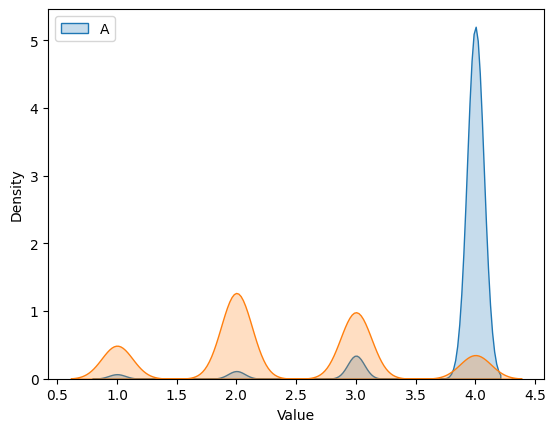

In [29]:
for t in target_variables:
    print(t)
    show_density(all_predictions[t][1], 'B')
    show_density(all_predictions[t][0], 'A', True)

# Evaluations

In [30]:
from sklearn.metrics import mean_absolute_error, cohen_kappa_score
from scipy.stats import spearmanr

In [32]:
t

'polintr'

In [31]:
for t, (y_true, y_pred) in all_predictions.items():
    # print("mean_absolute_error", t, mean_absolute_error(y_true, y_pred))
    print("cohen_kappa_score", t, cohen_kappa_score(y_true, y_pred))
    # print("spearmanr", t, spearmanr(y_true, y_pred)[0])

ValueError: Classification metrics can't handle a mix of multiclass and unknown targets

# Further Experiments

In [48]:
all_predictions

{'polintr': ([1,
   2,
   2,
   3,
   2,
   2,
   2,
   1,
   3,
   2,
   1,
   2,
   3,
   2,
   3,
   1,
   1,
   2,
   4,
   2,
   1,
   2,
   3,
   1,
   2,
   1,
   3,
   2,
   4,
   3,
   3,
   2,
   2,
   3,
   1,
   4,
   3,
   3,
   1,
   2,
   2,
   2,
   4,
   2,
   2,
   2,
   3,
   3,
   2,
   4,
   2,
   1,
   4,
   3,
   3,
   4,
   2,
   2,
   2,
   2,
   2,
   1,
   2,
   3,
   3,
   2,
   2,
   1,
   2,
   1,
   3,
   2,
   2,
   3,
   1,
   2,
   3,
   2,
   4,
   3,
   3,
   1,
   2,
   2,
   3,
   1,
   3,
   3,
   2,
   2,
   2,
   3,
   3,
   3,
   2,
   2,
   2,
   2,
   2,
   4,
   3,
   3,
   3,
   2,
   2,
   3,
   1,
   2,
   2,
   2,
   3,
   3,
   2,
   4,
   3,
   2,
   2,
   2,
   3,
   1,
   3,
   2,
   3,
   4,
   3,
   2,
   2,
   3,
   3,
   4,
   2,
   2,
   3,
   2,
   3,
   2,
   2,
   2,
   2,
   2,
   2,
   3,
   2,
   3,
   3,
   2,
   2,
   2,
   1,
   3,
   3,
   2,
   3,
   3,
   3,
   2,
   2,
   2,
   1,
   1,
   3,
   2,
   4,
   2,
   2,